In [185]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter as Cnt

plt.rcParams['font.sans-serif'] = ['Lucid']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [5]:
data_path = "./dataset"

In [6]:
os.listdir(data_path)

['link_phase1.csv',
 'graph.bin',
 'diff_nodes.csv',
 'sample_submission_for_validation.csv',
 'labels.pkl',
 '数据说明.md',
 'train_nodes.csv',
 'validation_nodes.csv',
 'IDandLabels.csv',
 'features.npy',
 '.ipynb_checkpoints']

In [142]:
with open(os.path.join(data_path, 'labels.pkl'), 'rb') as f:
    labels = pickle.load(f)
    

In [143]:
labels

{'tr_label_idx': array([   6018,    9505,    9507, ..., 2493585, 2493586, 2493587]),
 'val_label_idx': array([2343425, 2348861, 2349640, ..., 3051283, 3053140, 3058462]),
 'test_label_idx': array([3063061, 3063062, 3063063, ..., 3655449, 3655450, 3655451]),
 'label': array([18, -1,  6, ..., -1, -1, -1])}

# 分析连接关系

- 一共有多少边
- 哪些节点是游离的，train里哪些节点是游离的，validation里哪些结点是游离的
- 每个结点的入度和出度

In [16]:
%%time
id_labels = pd.read_csv(os.path.join(data_path, 'IDandLabels.csv'))
edges = pd.read_csv(os.path.join(data_path, 'link_phase1.csv'))

<decorator-gen-54>:2: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 32.8 s, sys: 2.4 s, total: 35.2 s
Wall time: 35.2 s


In [46]:
# 构建paper_id 到 node_idx的映射
paper_idx = dict(zip(id_labels['paper_id'].to_list(), id_labels['node_idx'].to_list()))

In [55]:
# 将原来的边列表转换为node_idx的边列表
edges_idx = pd.DataFrame({'node_idx': edges['paper_id'].apply(lambda e: paper_idx[e]), 'reference_node_id': edges['reference_paper_id'].apply(lambda e: paper_idx[e])})
edges_idx

,node_idx,reference_node_idx
0,529879,2364950
1,410481,384023
2,2196044,1895619
3,2545623,2175977
4,165064,1912514
...,...,...
29168645,2534866,25560
29168646,1944890,838369
29168647,1548308,585520
29168648,982077,1320220


In [ ]:
# 将转换为node_idx后的边列表保存
edges_idx.to_csv(os.path.join(data_path, 'link_phase1_node_idx.csv'), index=False)

In [64]:
g = edges_idx.groupby('node_idx')

In [75]:
ref_num = g.agg(len)

In [77]:
ref_g = edges_idx.groupby('reference_node_idx')

In [78]:
refed_num = ref_g.agg(len)

引文数量直方图和被引数量直方图

In [199]:
tt = Cnt(ref_num['reference_node_idx'])
tt.most_common(10)

[(1, 223984),
 (2, 208634),
 (3, 199283),
 (4, 190551),
 (5, 181905),
 (6, 171365),
 (7, 161650),
 (8, 148799),
 (9, 136829),
 (10, 124361)]

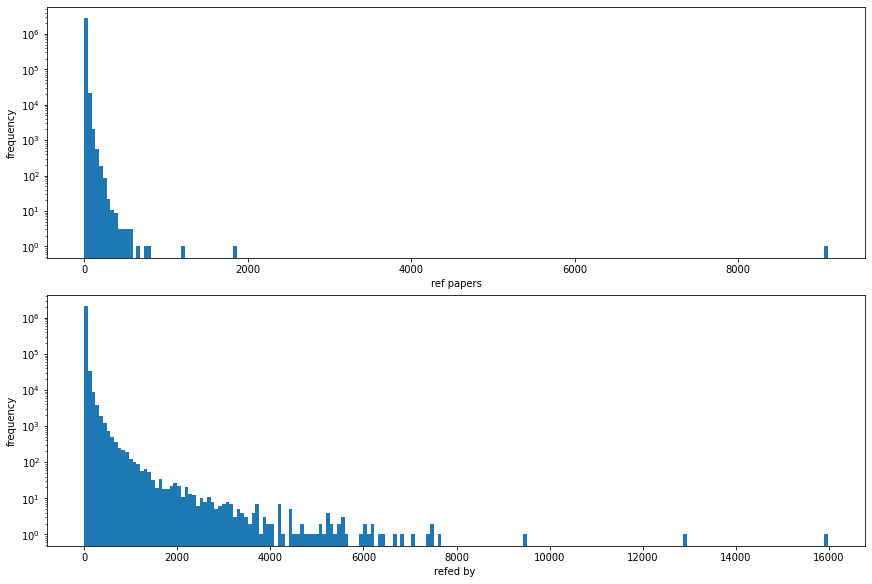

In [208]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=1)
_ = ax[0].hist(ref_num['reference_node_idx'], bins=200, log=1)
_ = ax[1].hist(refed_num['node_idx'], bins=200, log=1)

ax[0].set_ylabel('frequency')
ax[0].set_xlabel('ref papers') # x轴表示引用的文献数
ax[1].set_ylabel('frequency')
_ = ax[1].set_xlabel('refed by ') # x轴表示被多少文献引用了

In [137]:
all_nodes = set(edges_idx['node_idx'].to_list() + edges_idx['reference_node_idx'].to_list())

In [156]:
tri = set(labels['tr_label_idx'])
tri = tri.union(set(labels['val_label_idx']))

tes = set(labels['test_label_idx'])

In [176]:
free_tri = np.array(list(tri - all_nodes))
free_tes = np.array(list(tes - all_nodes))

free_tri.shape, free_tes.shape

((109060,), (88751,))

In [175]:
# 保存游离的结点的索引
with open(os.path.join(data_path, "free_nodes.pkl"), 'wb') as f:
    pickle.dump({
        'free_trian_idx': free_tri, 
        'free_test_idx': free_tes
    }, f)

In [219]:
id_labels

,node_idx,paper_id,Label,Split_ID
0,0,bfdee5ab86ef5e68da974d48a138c28e,S,0
1,1,78f43b8b62f040347fec0be44e5f08bd,NaN,0
2,2,a971601a0286d2701aa5cde46e63a9fd,G,0
3,3,ac4b88a72146bae66cedfd1c13e1552d,NaN,0
4,4,a48c92cc8f67a8327adac7ff62d24a53,W,0
...,...,...,...,...
3655447,3655447,ce9f6a2278633a2dd47838b5e62e15f1,NaN,1
3655448,3655448,caed47d55d1e193ecb1fa97a415c13dd,NaN,1
3655449,3655449,c82eb6be79a245392fb626b9a7e1f246,NaN,1
3655450,3655450,926a31f6b378575204aae30b5dfa6dd3,NaN,1


# 类别分布

In [210]:
label = labels['label']
label = label[label!=-1]

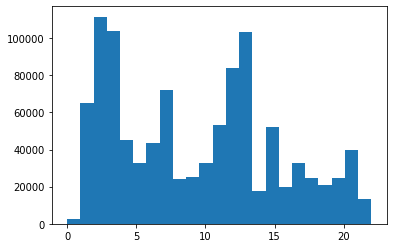

In [214]:
_ = plt.hist(label, bins=23, log=0, density=0)

In [215]:
Cnt(label)

Counter({18: 24609,
         6: 43452,
         22: 13111,
         7: 71824,
         8: 23994,
         4: 45014,
         16: 19676,
         12: 83971,
         15: 52166,
         11: 53391,
         19: 20878,
         2: 111502,
         3: 104005,
         9: 25241,
         1: 65303,
         20: 24740,
         5: 32876,
         21: 39557,
         13: 103472,
         14: 17593,
         10: 32762,
         17: 32610,
         0: 2670})